In [1]:
import os
import pandas

import numpy as np
import itertools

from multiprocessing import Pool

import scipy as sp
from scipy import optimize

import pickle as pkl

def exgauss_pdf(x, mu, sigma, nu):

    nu = 1./nu

    p1 = nu / 2. * np.exp((nu/2.)  * (2 * mu + nu * sigma**2. - 2. * x))


    p2 = sp.special.erfc((mu + nu * sigma**2 - x)/ (np.sqrt(2.) * sigma))

    return p1 * p2

def mixed_exgauss_likelihood(x, w, mu, sigma, nu):

    # Create indiviudal
    pdfs = w * exgauss_pdf(x[:, np.newaxis], mu, nu, sigma)

    ll = np.sum(np.log(np.sum(pdfs, 1)))

    if ((np.isnan(ll)) | (ll == np.inf)):
        return -np.inf


    return ll

def input_optimizer(pars, x, n_clusters):

    pars = np.array(pars)

    if np.sum(pars[:n_clusters-1]) > 1:
        return np.inf

    pars = np.insert(pars, n_clusters-1, 1 - np.sum(pars[:n_clusters-1]))

    if np.any(pars[:n_clusters] < 0.05):
        return np.inf

    w = pars[:n_clusters][np.newaxis, :]
    mu = pars[n_clusters:n_clusters*2][np.newaxis, :]
    nu = pars[n_clusters*2:n_clusters*3][np.newaxis, :]
    sigma = pars[n_clusters*3:n_clusters*4][np.newaxis, :]

    return -mixed_exgauss_likelihood(x, w, mu, sigma, nu)


def _fit(input_args, disp=False, popsize=100, **kwargs):

    sp.random.seed()

    x, n_clusters = input_args

    weight_bounds = [(1e-3, 1)] * (n_clusters - 1)
    mu_bounds = [(-1., 2.5)] * n_clusters
    nu_bounds = [(1e-3, 2.5)] * n_clusters
    sigma_bounds = [(1e-3, 2.5)] * n_clusters

    bounds = weight_bounds + mu_bounds + nu_bounds + sigma_bounds

    result = sp.optimize.differential_evolution(input_optimizer, bounds, (x, n_clusters), polish=True, disp=disp, maxiter=500, popsize=popsize, **kwargs)
    result = sp.optimize.minimize(input_optimizer, result.x, (x, n_clusters), method='SLSQP', bounds=bounds, **kwargs)

    return result

class SimpleExgaussMixture(object):


    def __init__(self, data, n_clusters):

        self.data = data
        self.n_clusters = n_clusters
        self.n_parameters = n_clusters * 4 - 1
        self.likelihood = -np.inf

        self.previous_likelihoods = []
        self.previous_pars = []


    def get_likelihood_data(self, data):
        
        return mixed_exgauss_likelihood(data, self.w, self.mu, self.sigma, self.nu)

    def _fit(self, **kwargs):
        return _fit((self.data, self.n_clusters), **kwargs)



    def fit(self, n_tries=1, **kwargs):
        for run in np.arange(n_tries):

            result = self._fit(**kwargs)
            self.previous_likelihoods.append(-result.fun)

            if -result.fun > self.likelihood:

                pars = result.x
                pars = np.insert(pars, self.n_clusters-1, 1 - np.sum(pars[:self.n_clusters-1]))

                self.w = pars[:self.n_clusters][np.newaxis, :]
                self.mu = pars[self.n_clusters:self.n_clusters*2][np.newaxis, :]
                self.nu = pars[self.n_clusters*2:self.n_clusters*3][np.newaxis, :]
                self.sigma = pars[self.n_clusters*3:self.n_clusters*4][np.newaxis, :]

                self.likelihood = -result.fun

        self.aic = 2 * self.n_parameters - 2 * self.likelihood
        self.bic = - 2 * self.likelihood + self.n_parameters * np.log(self.data.shape[0])



    def fit_multiproc(self, n_tries=4, n_proc=4, disp=False):

        pool = Pool(n_proc)

#         print 'starting pool'
        results = pool.map(_fit, [(self.data, self.n_clusters)] * n_tries)
#         print 'ready'

#         print results



        pool.close()

        for result in results:
            self.previous_likelihoods.append(-result.fun)
            self.previous_pars.append(result.x)

            if -result.fun > self.likelihood:

                pars = result.x
                pars = np.insert(pars, self.n_clusters-1, 1 - np.sum(pars[:self.n_clusters-1]))

                self.w = pars[:self.n_clusters][np.newaxis, :]
                self.mu = pars[self.n_clusters:self.n_clusters*2][np.newaxis, :]
                self.nu = pars[self.n_clusters*2:self.n_clusters*3][np.newaxis, :]
                self.sigma = pars[self.n_clusters*3:self.n_clusters*4][np.newaxis, :]

                self.likelihood = -result.fun

        self.aic = 2 * self.n_parameters - 2 * self.likelihood
        self.bic = - 2 * self.likelihood + self.n_parameters * np.log(self.data.shape[0])

    def plot_fit(self):
        # Create indiviudal pds

        t = np.linspace(0, self.data.max(), 100)
        pdfs = self.w * exgauss_pdf(t[:, np.newaxis], self.mu, self.nu, self.sigma)

        sns.distplot(self.data)
        plt.plot(t, pdfs, c='k', alpha=0.5)

        plt.plot(t, np.sum(pdfs, 1), c='k', lw=2)

In [2]:
import pandas
import glob
import re

# Image intensity

In [27]:
fns = glob.glob('/home/gdholla1/data/post_mortem/ml_clusters_v2/*.pkl')
reg = re.compile('.*/(?P<subject_id>[0-9]+)_(?P<fwhm>[0-9]+\.[0-9]+)_(?P<stain>.*)_(?P<n_clusters>[0-9]+)\.pkl')


fns = [fn for fn in fns if reg.match(fn)]
df = pandas.DataFrame([reg.match(fn).groupdict() for fn in fns])
df['fn'] = fns
df['fwhm'] = df['fwhm'].astype(float)
# df['bic'] = df.fn.apply(lambda fn: pkl.load(open(fn)).bic)
# df['aic'] = df.fn.apply(lambda fn: pkl.load(open(fn)).aic)
df['fit_object'] = df.fn.apply(lambda fn: pkl.load(open(fn)))

df['bic'] = df.fit_object.apply(lambda x: x.bic)
df['aic'] = df.fit_object.apply(lambda x: x.bic)

In [28]:
def get_proportion_surely_one_cluster(row):
    
    fit_object = row.fit_object
    pdfs = fit_object.w * exgauss_pdf(fit_object.data[:, np.newaxis], fit_object.mu, fit_object.nu, fit_object.sigma)
#      = row.w * exgauss_pdf(row.data[:, np.newaxis], row.mu, row.nu, row.sigma)
    
    return ((pdfs.max(1) / pdfs.sum(1)) > 0.95).mean()

In [29]:
df['Proportion of strong cluster assignments'] = df.apply(get_proportion_surely_one_cluster, 1)

In [30]:
df['Number of clusters'] = df['n_clusters']

In [31]:
sns.set_context('poster')
sns.set_style('whitegrid')

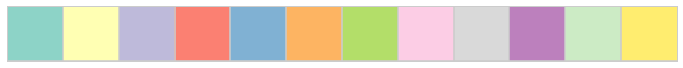

In [32]:
sns.palplot(sns.color_palette('Set3', 12))

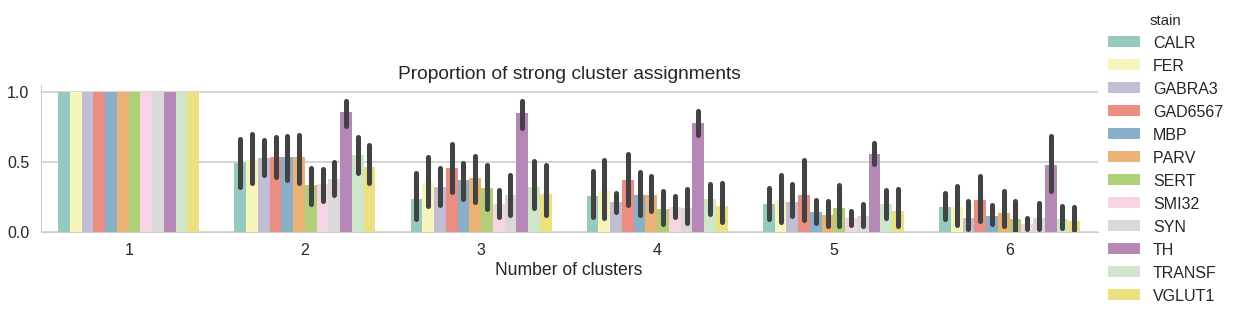

In [33]:
tmp = df.groupby(['subject_id', 'Number of clusters', 'stain']).mean()

fac = sns.factorplot('Number of clusters', 'Proportion of strong cluster assignments', 'stain', tmp.reset_index(), kind='bar', palette=sns.color_palette('Set3', 12), aspect=4)

fac.set_ylabels('')

fac.ax.set_title('Proportion of strong cluster assignments')

plt.savefig('/home/gdholla1/projects/post_mortem/reports/proportion_strong_cluster_assignments.pdf')

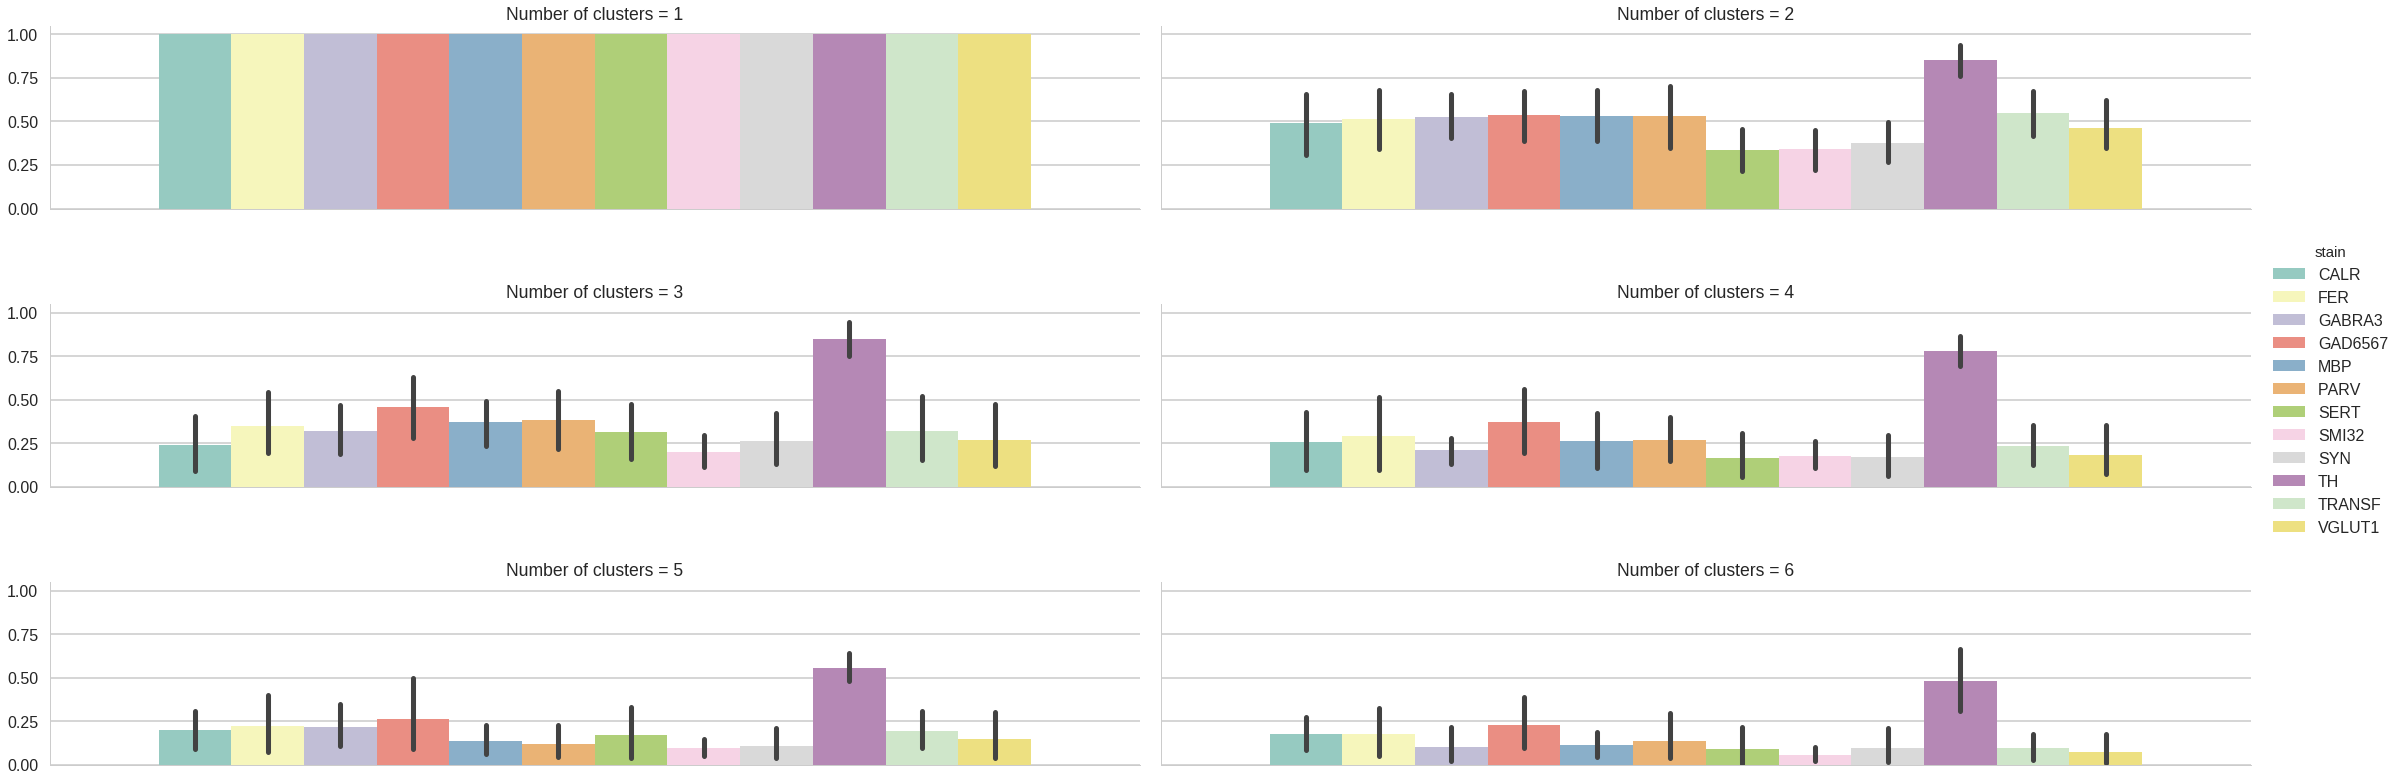

In [34]:
tmp['dummy'] = 1
fac = sns.factorplot('dummy', 'Proportion of strong cluster assignments', 'stain', tmp.reset_index(), col='Number of clusters', col_wrap=2, kind='bar', palette=sns.color_palette('Set3', 12), aspect=4)

fac.set_ylabels('')
fac.set_axis_labels(x_var='')
fac.set_xlabels('')
fac.set_xticklabels([])
plt.savefig('/home/gdholla1/projects/post_mortem/reports/proportion_strong_cluster_assignments_edit.pdf')

# Gradients

In [35]:
fns = glob.glob('/home/gdholla1/data/post_mortem/ml_clusters_gradient//*.pkl')
reg = re.compile('.*/(?P<subject_id>[0-9]+)_(?P<fwhm>[0-9]+\.[0-9]+)_(?P<stain>.*)_(?P<n_clusters>[0-9]+)\.pkl')


fns = [fn for fn in fns if reg.match(fn)]
df = pandas.DataFrame([reg.match(fn).groupdict() for fn in fns])
df['fn'] = fns
df['fwhm'] = df['fwhm'].astype(float)
# df['bic'] = df.fn.apply(lambda fn: pkl.load(open(fn)).bic)
# df['aic'] = df.fn.apply(lambda fn: pkl.load(open(fn)).aic)
df['fit_object'] = df.fn.apply(lambda fn: pkl.load(open(fn)))

df['bic'] = df.fit_object.apply(lambda x: x.bic)
df['aic'] = df.fit_object.apply(lambda x: x.bic)

In [36]:
df['Proportion of strong cluster assignments'] = df.apply(get_proportion_surely_one_cluster, 1)

In [37]:
df['Number of clusters'] = df['n_clusters']

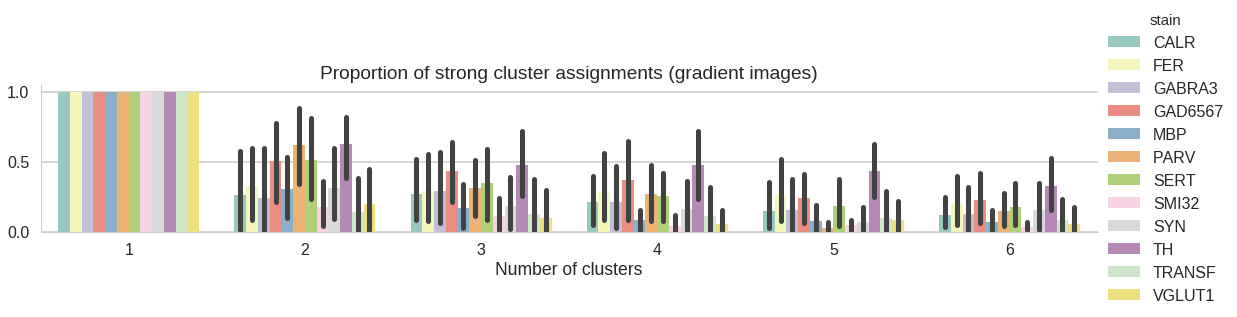

In [38]:
tmp = df.groupby(['subject_id', 'Number of clusters', 'stain']).mean()

fac = sns.factorplot('Number of clusters', 'Proportion of strong cluster assignments', 'stain', tmp.reset_index(), kind='bar', palette=sns.color_palette('Set3', 12), aspect=4)

fac.set_ylabels('')

fac.ax.set_title('Proportion of strong cluster assignments (gradient images)')

plt.savefig('/home/gdholla1/projects/post_mortem/reports/proportion_strong_cluster_assignments_gradient_images.pdf')

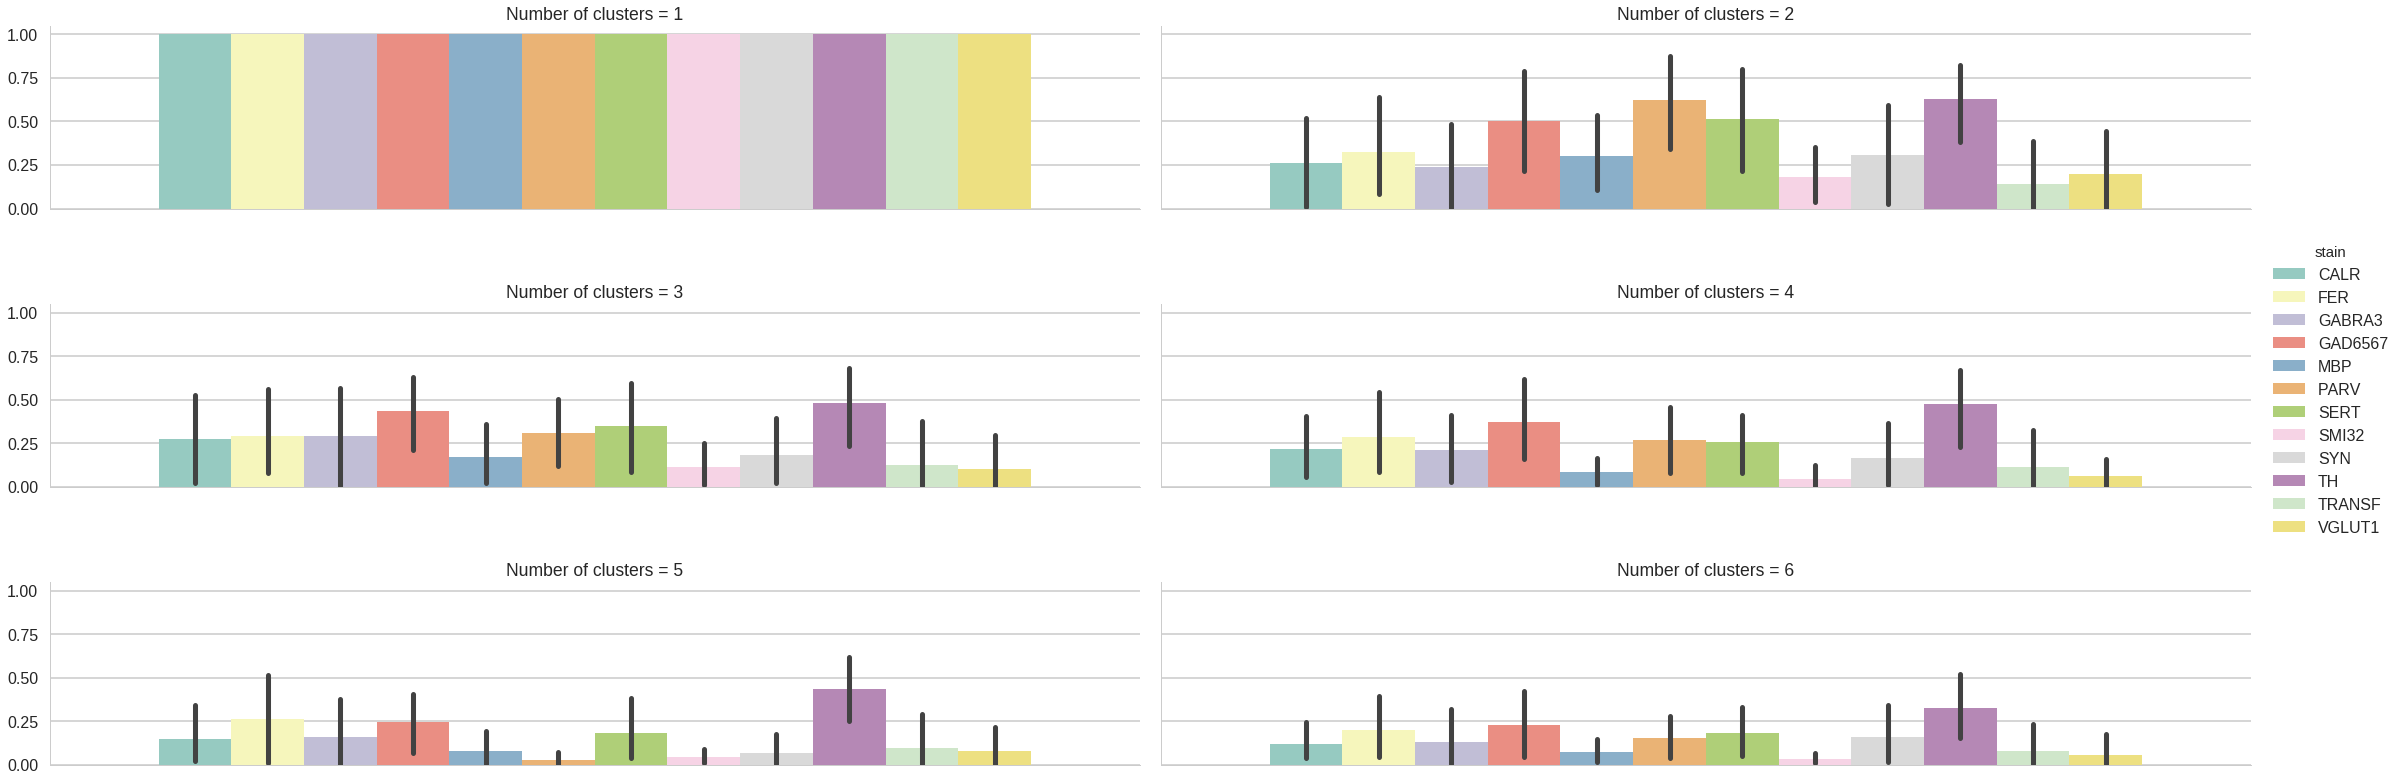

In [39]:
tmp['dummy'] = 1
fac = sns.factorplot('dummy', 'Proportion of strong cluster assignments', 'stain', tmp.reset_index(), col='Number of clusters', col_wrap=2, kind='bar', palette=sns.color_palette('Set3', 12), aspect=4)

fac.set_ylabels('')
fac.set_axis_labels(x_var='')
fac.set_xlabels('')
fac.set_xticklabels([])
plt.savefig('/home/gdholla1/projects/post_mortem/reports/proportion_strong_cluster_assignments_gradient_images_edit.pdf')